Import Python Libraries

In [1]:
# Import Python modules
import os, sys
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
# from sklearn.cluster import KMeans
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence
from eofs import *
from ar_funcs import preprocess_ar_area_subregions
# from kmeans import *

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


### Prepare Data

Read the data.

In [3]:
filename_pattern  = '/home/voyager-sbarc/arc/sst/hadisst/HadISST_sst.nc'
ds = xr.open_dataset(filename_pattern)
ds

# Create new dataset with just sst
new_ds = xr.Dataset({'sst': (['time', 'lat', 'lon'], ds.sst.values)},
                  coords={'time': (['time'], ds.time.values),
                          'lat': (['lat'], ds.latitude.values),
                          'lon': (['lon'], ds.longitude.values)})


Crop the data to 30S-30N.

In [4]:
## Set variable names (for saving data/figs)
var_names = 'SLP'
eofmode = 't' # s or t
dispmat = 'cov' # dispersion matrix type correlation/covariance

## Select lat/lon grid 
lonmin = -180
lonmax = 180
latmin = -30
latmax =  30

# for figure names for testing different configurations
fname_id = var_names + eofmode + str(lonmin) + str(lonmax) + str(latmin) + str(latmax) + dispmat

ds_subset = new_ds.sel(lat=slice(latmax,latmin), time=slice('1900-01-16', '2017-12-16'))
ds_subset

<xarray.Dataset>
Dimensions:  (lat: 60, lon: 360, time: 1416)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2017-12-16T12:00:00
  * lat      (lat) float32 29.5 28.5 27.5 26.5 25.5 ... -26.5 -27.5 -28.5 -29.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    sst      (time, lat, lon) float32 18.747246 18.713486 ... 22.220596

Compute the annual cycle of SST fitting the first and second harmonics.

Create 1st two harmonics and add together

In [5]:
def fourier(ds,p):
    time = ds.month
    n = len(time) 
 
    ds,time = xr.broadcast(ds,time)

    f = 2.*np.pi*p/n
    ft = f*time

    sum_a = ds*np.cos(ft - 1.)
    sum_b = ds*np.sin(ft - 1.)
    coef_a = (2./n)*sum_a.sum('month',skipna=True)
    coef_b = (2./n)*sum_b.sum('month',skipna=True)

    return ft,coef_a, coef_b

def harmonic(ds):
    a0 = ds.mean('month',skipna=True)

    #-First Harmonic
    p     = 1
    ft,coef_a,coef_b = fourier(ds,p)
    harm1 = a0 + coef_a*np.cos(ft-1.) + coef_b*np.sin(ft-1.)

    #-Second Harmonic
    p     = 2
    ft,coef_a,coef_b = fourier(ds,p)
    harm2 = a0 + coef_a*np.cos(ft-1.) + coef_b*np.sin(ft-1.)

    #-First plus second
    combo = harm1 + coef_a*np.cos(ft-1.) + coef_b*np.sin(ft-1.)

    return combo

In [6]:
climatology = ds_subset.groupby('time.month').mean('time')
climatology

annual_cycle = harmonic(climatology)
annual_cycle

anomalies = ds_subset.groupby('time.month') - annual_cycle
anomalies.sst.shape

/home/sbarc/students/nash/anaconda3/envs/pyclivac/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(1416, 60, 360)

Set variables for EOF analysis

In [7]:
var1 = anomalies.sst

var_list = [var1]

# Check that sizes of arrays match
for i, in_array in enumerate(var_list):
    # Extract variable as numpy array
    var1 = in_array.values
    print(var1.shape)


(1416, 60, 360)


Reshape, center, remove nans, and standardize data matrix.

In [8]:
%%time
# Weight the data by the square root of the cosine of the lat
var_list = spatial_weights(var_list)

## Flatten data to [time x space]
var_list = flatten_array(var_list)

## Center data
var_list = center_data(var_list)

## Remove nans
var_list, var_list_nan = remove_nans(var_list)


Nans removed success is  True
CPU times: user 1.29 s, sys: 686 ms, total: 1.98 s
Wall time: 1.98 s


In [9]:
## Standardize and put into single data matrix
## Array without missing values removed
Xs_wnan = standardize_arrays(var_list, mode=eofmode, dispersion_matrix=dispmat)

## Array with missing values removed
Xs = standardize_arrays(var_list_nan, mode=eofmode, dispersion_matrix=dispmat)

EOF mode:  t
Dispersion Matrix:  cov
(21600, 1416)
Column means:  nan
Column std:  nan
EOF mode:  t
Dispersion Matrix:  cov
(16378, 1416)
Column means:  0.0
Column std:  0.42


### EOF Analysis

In [11]:
%%time

# Compute eigenvalues & eigenvectors
R, evals, evecs = calc_eigs(Xs, mode=eofmode)

print('Eigenvalues: ', evals.shape)
print(evals, '\n')

print('Eigenvectors: ', evecs.shape)
print(np.round(evecs, 3), '\n')

Eigenvalues:  (1416,)
[7.46178026e+01 1.78796273e+01 1.72280763e+01 ... 6.70987626e-04
 8.18677740e-04 7.06580806e-04] 

Eigenvectors:  (1416, 1416)
[[ 0.053 -0.001  0.015 ... -0.019 -0.002  0.005]
 [ 0.048 -0.016  0.013 ... -0.039  0.036 -0.014]
 [ 0.044 -0.008  0.019 ...  0.016  0.027  0.011]
 ...
 [-0.032  0.016 -0.044 ...  0.     0.004  0.008]
 [-0.034  0.034 -0.053 ...  0.002  0.003 -0.001]
 [-0.036  0.04  -0.048 ... -0.022  0.009  0.006]] 

CPU times: user 10min 44s, sys: 19.2 s, total: 11min 3s
Wall time: 14.4 s


Text(0.5, 1.0, 'Dispersion Matrix (cov)')

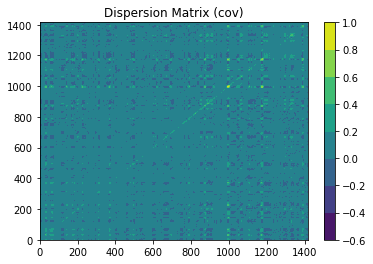

In [12]:
plt.contourf(R)
plt.colorbar()
title = 'Dispersion Matrix (' + dispmat + ')'
plt.title(title)

### Explained Variance

In [13]:
# Calculate the percent explained var by each eigenvector
pctvar = pct_variance(evals)

# Number of EOFs that explain more than 1% of the total variance
idx = pctvar[pctvar >= 1.0]
neofs = len(idx)

# print exp var >= 1.0
cumvar = np.sum(pctvar[0:neofs-1])
print(f'Cumulative variance explained by the first {neofs} EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var: neofs = 4
cumvar = np.sum(pctvar[0:3])
print(f'Cumulative variance explained by the first 4 EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var for 4 eofs
for k in range(4):
    print(f'{k+1} \t {pctvar[k]:.2f}%')

Cumulative variance explained by the first 18 EOFs:
72.63% 

Cumulative variance explained by the first 4 EOFs:
40.77% 

1 	 27.73%
2 	 6.64%
3 	 6.40%
4 	 4.23%


### North Test

In [14]:
total_events = len(evecs)
err = north_test(evals, total_events)
upper = pctvar + err
lower = pctvar - err

print(np.round(upper[0:6],3))
print(np.round(pctvar[0:6],3))
print(np.round(lower[0:6],3))

[28.768  6.893  6.642  4.388  3.97   3.618]
[27.726  6.644  6.401  4.229  3.826  3.487]
[26.684  6.394  6.161  4.07   3.683  3.356]


### Fig Variance

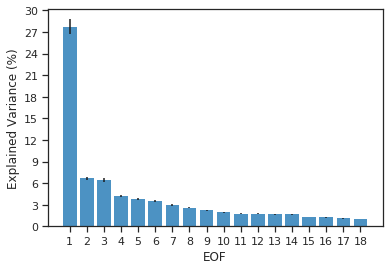

In [15]:
# set seaborn style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# create figure
fig, ax = plt.subplots(figsize=(6,4))

# plot data
xvals = np.arange(neofs) + 1
ax.bar(xvals, pctvar[0:neofs], yerr=err[0:neofs], 
       color='tab:blue', alpha=0.8)

# x-axis
ax.set_xlabel('EOF')
ax.set_xticks(xvals)

# y-axis
ax.set_ylabel('Explained Variance (%)')
yticks = np.arange(0,31,3)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks) 

# save fig
filepath = path_to_figs + 'exp_variance_' + fname_id + '.png'
plt.savefig(filepath, dpi=300)

# show
plt.show()

### Loadings

In [16]:
neofs = 19
loads = loadings(evals, evecs, neofs)

print(loads.shape)
print(np.round(loads,3))

(1416, 19)
[[ 0.46  -0.005  0.063 ... -0.012 -0.073  0.021]
 [ 0.416 -0.069  0.054 ...  0.013 -0.06   0.02 ]
 [ 0.382 -0.035  0.079 ...  0.006 -0.021 -0.03 ]
 ...
 [-0.279  0.067 -0.184 ...  0.049  0.032 -0.035]
 [-0.292  0.145 -0.219 ... -0.034  0.02  -0.068]
 [-0.312  0.169 -0.201 ... -0.052  0.043 -0.049]]


In [17]:
# Save eigenvalues, eigenvectors, and loadings

neofs = 4   # number of EOFs to save (evecs, loadings3)

outfile = path_to_out + 'eigenvalues_'+ fname_id + '.txt'
np.savetxt(outfile, evals, fmt='%.5f')

outfile = path_to_out + 'eigenvectors_'+ fname_id + '.txt'
np.savetxt(outfile, evecs[:,0:neofs], fmt='%.5f', delimiter=',')

outfile = path_to_out + 'loadings_'+ fname_id + '.txt'
np.savetxt(outfile, loads[:,0:neofs], fmt='%.4f', delimiter=',')


### PCs

In [19]:
# Calculate principal components (spatial modes)
neofs = 4
pcs = calc_eofs(Xs_wnan, evecs, neofs, mode=eofmode)
pcs.shape

(4, 21600)

In [20]:
# Split pcs into separate arrays for each variable
ntim, nlat, nlon = var1.shape
npts = nlat*nlon
nvar = len(var_list)
# Reshape spatial dim back to 2D map
pcmodes = var_list
for i in np.arange(len(var_list)):
    tmp = pcs[:,i*npts:(i+1)*npts]
    pcmodes[i] = np.reshape(tmp, (neofs,nlat,nlon))

### Fig. Spatial Modes

In [21]:
# Panel Plot of Spatial Modes

# number of eofs to plot
neofs = 4

# Data for plotting extratropics
lons = ds_subset.lon.data
lats = ds_subset.lat.data
data = pcmodes[0][0:neofs,:,:]

print(np.nanmin(data), np.nanmax(data))

# Set up projection
mapcrs = ccrs.PlateCarree(central_longitude=-179.5)
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subtitles
eof_label = [ ]
pc_label = [ ]
var_label = [ ]
for k in range(neofs):
    eof_label.append("EOF{:1d}".format(k+1,))
    pc_label.append("PC{:1d}".format(k+1,))
    var_label.append("{:.2f}%".format(pctvar[k]))

nan nan


/home/sbarc/students/nash/anaconda3/envs/pyclivac/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: All-NaN slice encountered
  # This is added back by InteractiveShellApp.init_path()


In [23]:
data.shape

(4, 60, 360)

In [22]:
# Create figure
fig = plt.figure(figsize=(10,11))
filepath = path_to_figs + 'eofs_'+ fname_id + '.png'
nrows = 4
ncols = 1

# sns.set_style('ticks')

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 
                111, 
                axes_class=axes_class,
                nrows_ncols=(nrows, ncols), 
                axes_pad = 0.55,
                cbar_location='bottom', 
                cbar_mode='single',
                cbar_pad=0.0, 
                cbar_size='10%',
                label_mode='')

#newcmap = cmocean.tools.crop_by_percent(cmo.matter, 15, which='max', N=None)

# Loop for drawing each plot
for k, ax in enumerate(axgr):
#     ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], grid=True)
    # Add contour fill plot for extratropics
#     clevs = np.arange(-3,3.5,.5)
    clevs = np.arange(-30,35,5)
    cf = ax.contourf(lons, lats, data[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
    
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.set_title(var_label[k], loc='right', fontsize=12)
    
# single colorbar
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('m', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Display figure
plt.savefig(filepath, dpi=200, bbox_inches='tight')
plt.show()

/home/sbarc/students/nash/anaconda3/envs/pyclivac/lib/python3.7/site-packages/matplotlib/contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/sbarc/students/nash/anaconda3/envs/pyclivac/lib/python3.7/site-packages/matplotlib/contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


ValueError: 'bboxes' cannot be empty

IndexError: too many indices for array

<Figure size 720x792 with 8 Axes>

/home/nash/DATA/repositories/AR_types/figs/pc_SLPt-180180-3030cov.png


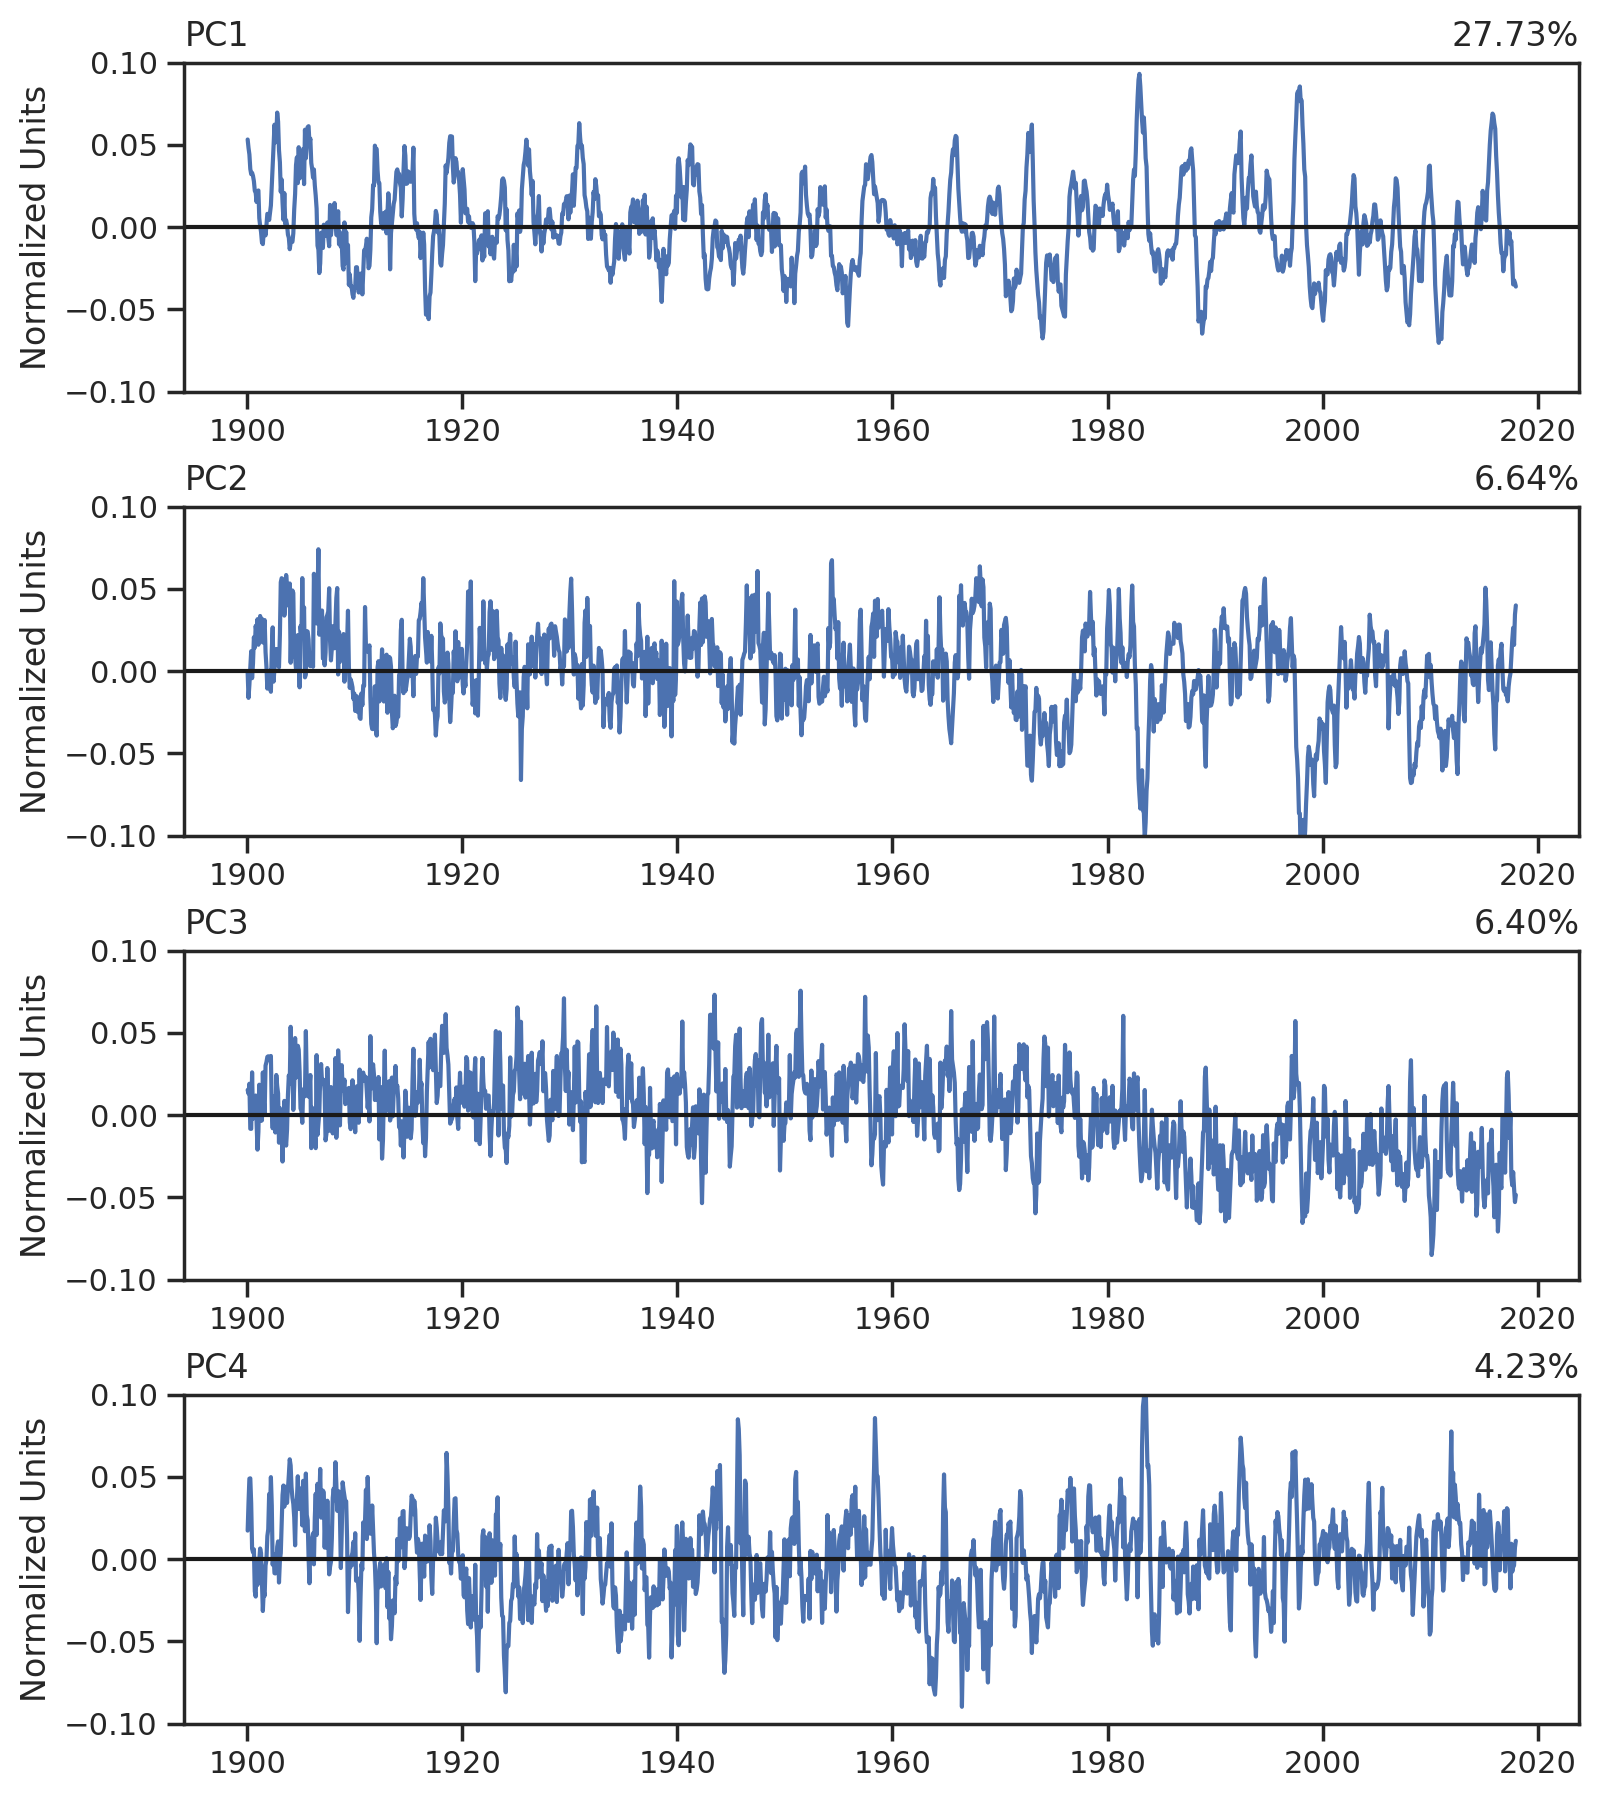

<Figure size 1800x2200 with 0 Axes>

In [22]:
fig = plt.figure(figsize=(9,11))
fig.dpi = 200
fname = path_to_figs + 'pc_'+ fname_id
fmt = 'png'
results = evecs[:,:4]
subtitles = ['PC1', 'PC2', 'PC3', 'PC4']

X, nplots = results.shape

for i in np.arange(nplots):
    ax = plt.subplot(4, 1, i+1)
    ax.plot_date(ds_subset.time.values, results[:,i], '-')
    ax.axhline(0, color='k')
    ax.set_ylim(-0.1, 0.1)
    ax.set_ylabel('Normalized Units')
    # subtitles
    ax.set_title(pc_label[i], loc='left', fontsize=12)
    ax.set_title(var_label[i], loc='right', fontsize=12)

plt.subplots_adjust(hspace=0.35, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))